In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers
import os

print(tf.version.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [48]:
train_dir = 'chest-xray-pneumonia/chest_xray/train'
test_dir =  'chest-xray-pneumonia/chest_xray/test'
X = []
Y = []

#Loop through the training and test folders, as well as the 'NORMAL' and 'PNEUMONIA' subfolders and append all images into array X.  Append the classification (0 or 1) into array Y.

for fileName in os.listdir(train_dir + "/NORMAL"): 
        img = cv2.imread(train_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(train_dir + "/PNEUMONIA"): 
        img = cv2.imread(train_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)
            
for fileName in os.listdir(test_dir + "/NORMAL"): 
        img = cv2.imread(test_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(test_dir + "/PNEUMONIA"): 
        img = cv2.imread(test_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)

Patient with Pneumonia:


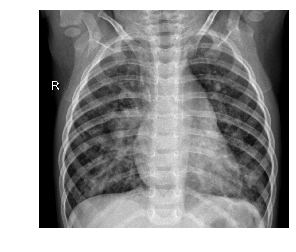

In [15]:
print("Patient with Pneumonia:")
pnumonia = cv2.imread(test_dir + "/PNEUMONIA/person15_virus_46.jpeg")
plt.axis('off')
plt.imshow(pnumonia)

Patient without pneumonia:


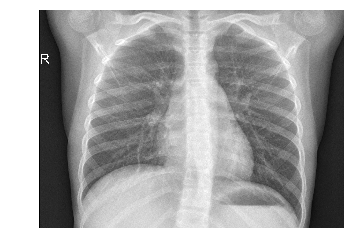

In [16]:
print("Patient without pneumonia:")
normal = cv2.imread(test_dir + "/NORMAL/IM-0003-0001.jpeg")
plt.axis('off')
plt.imshow(normal)

### Data Normalization

First we need to normalize the data. As pixels in images can only range from 0 to 255 we divide by 255 as it is the maximum value.

For our labels, we will transform it to a categorical matrix. 

In [49]:
X = np.array(X)/255
X = (X - np.average(X,0))/np.std(X,0)

In [20]:
#Y = tf.keras.utils.to_categorical(Y, num_classes = 2)

In [72]:
Y_ = np.array(Y)
Y_ = Y_.astype(int)

### Splitting Data 

We will partition our dataset into training, test and validation datasets. 

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, Y_,
                                                    stratify=Y, 
                                                    test_size=0.4)

In [76]:
X_validation, X_test, y_validation, y_test = train_test_split(X_test_validation, y_test_validation,
                                                    stratify=y_test_validation, 
                                                    test_size=0.5)

In [77]:
print("Training set: ", X_train.shape)
print("Test set: ",X_test.shape)
print("Validation set: ",X_validation.shape)

Training set:  (3504, 64, 64, 3)
Test set:  (1168, 64, 64, 3)
Validation set:  (1168, 64, 64, 3)


## Defining the Convolutional Neural Network

In [78]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]

In [79]:
model = tf.keras.Sequential()
model.add(layers.Convolution2D(32,(3,3), input_shape=(img_width,img_height,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

###classification layer
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                589888    
__________

In [87]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
3504/3504 [==============================] - 21s 6ms/sample - loss: 0.2291 - acc: 0.9087
Epoch 2/5
3504/3504 [==============================] - 22s 6ms/sample - loss: 0.1442 - acc: 0.9458
Epoch 3/5
3504/3504 [==============================] - 23s 7ms/sample - loss: 0.1105 - acc: 0.9569
Epoch 4/5
3504/3504 [==============================] - 23s 7ms/sample - loss: 0.0946 - acc: 0.9615
Epoch 5/5
3504/3504 [==============================] - 24s 7ms/sample - loss: 0.0833 - acc: 0.9686


In [88]:
score = model.evaluate(X_test, y_test)

1168/1168 [==============================] - 3s 2ms/sample - loss: 0.1631 - acc: 0.9384


## Hidden layers as intermediate representations

In [95]:
layer_outputs = [layer.output for layer in model.layers[:8]] 
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) 

In [96]:
activation_model

### make a prediction using the activation model

In [126]:
image = cv2.imread(test_dir + "/PNEUMONIA/person15_virus_46.jpeg")
image = cv2.resize(image,(64,64))
image = image.reshape(1,64,64,3)

In [123]:
image.shape

(64, 64, 3)

In [127]:
activations = activation_model.predict(image)

In [145]:
first_layer_activation =np.array(activations[0])

Exception ignored in: <function BaseSession._Callable.__del__ at 0x0000026FED5FE6A8>
Traceback (most recent call last):
  File "C:\Users\jctep\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1452, in __del__
    if self._handle is not None and self._session._session is not None:
KeyboardInterrupt


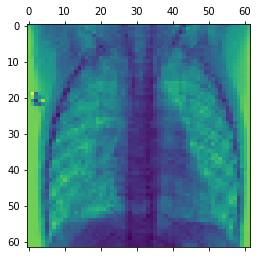

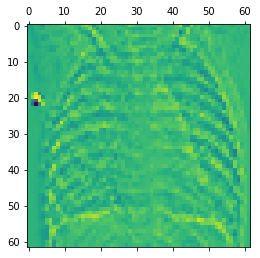

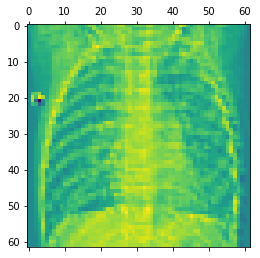

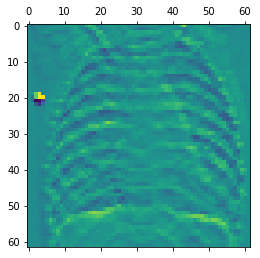

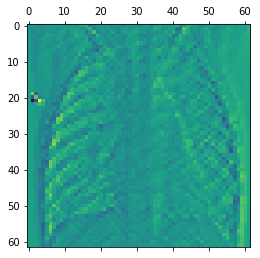

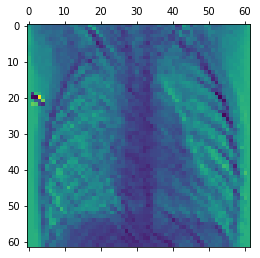

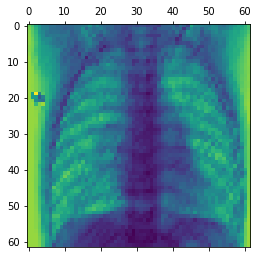

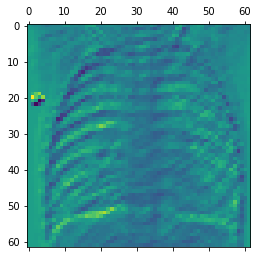

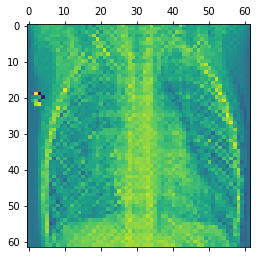

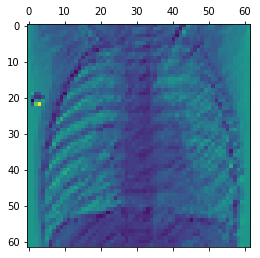

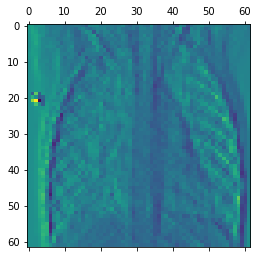

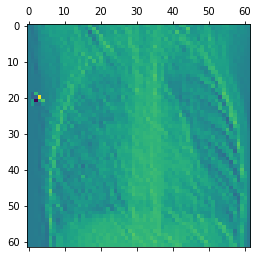

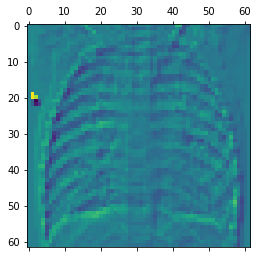

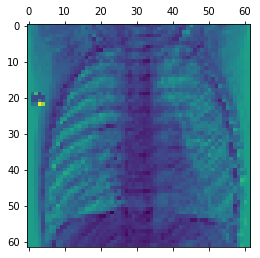

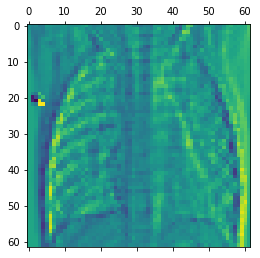

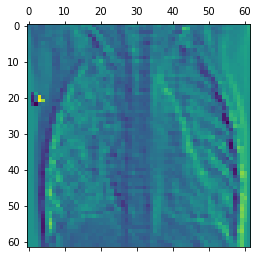

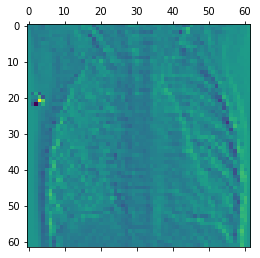

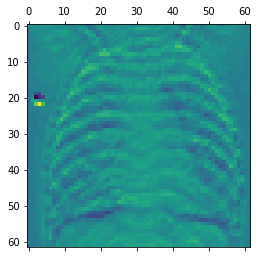

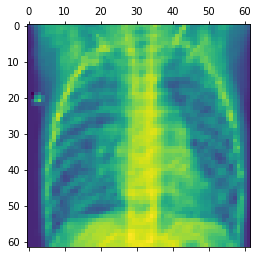

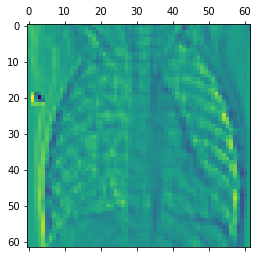

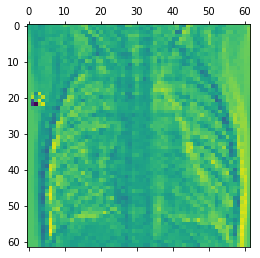

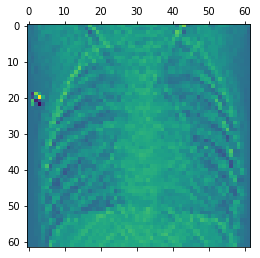

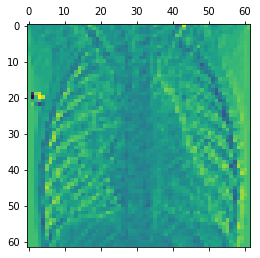

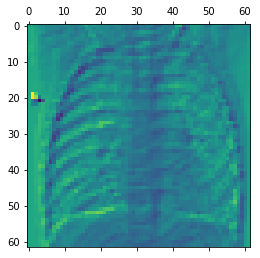

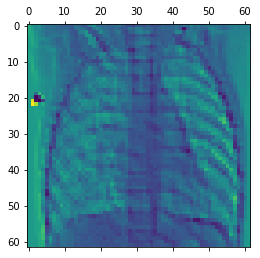

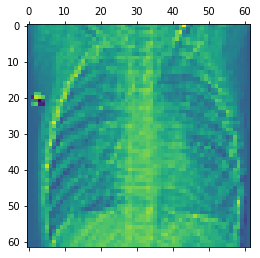

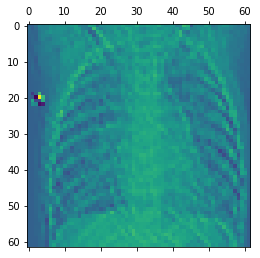

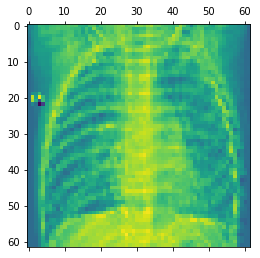

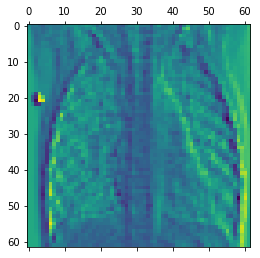

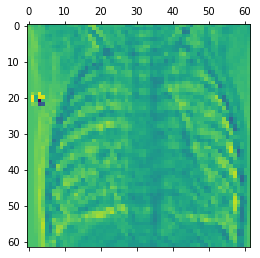

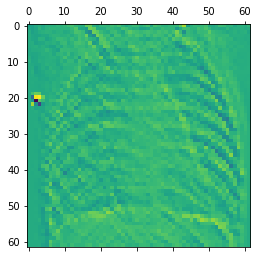

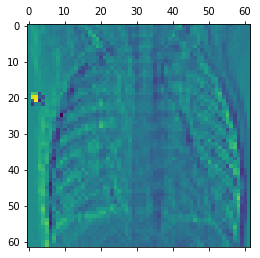

In [158]:
channels = first_layer_activation.shape[3]
i = 0
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1

IndexError: index 32 is out of bounds for axis 3 with size 32

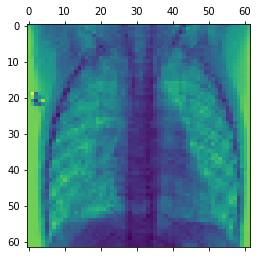

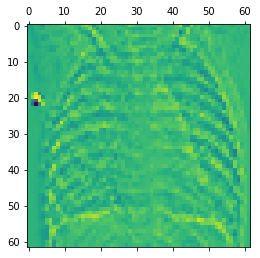

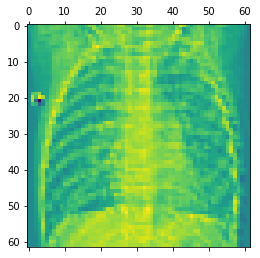

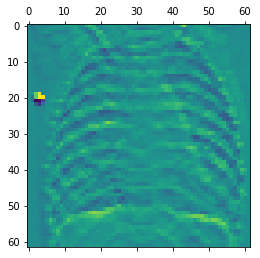

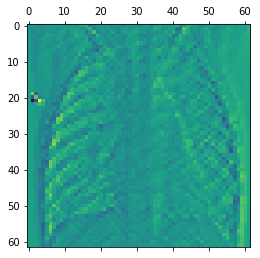

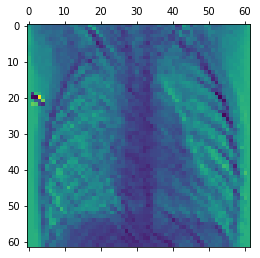

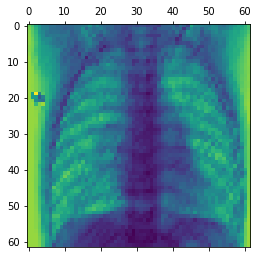

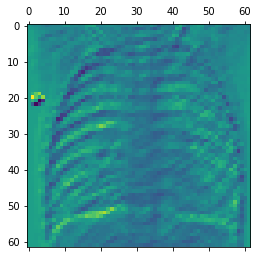

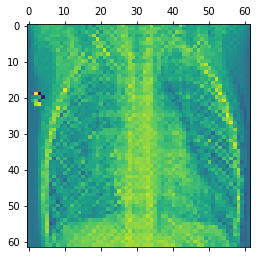

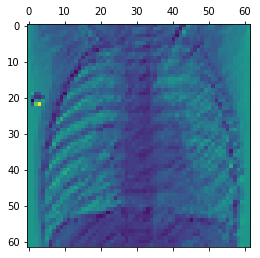

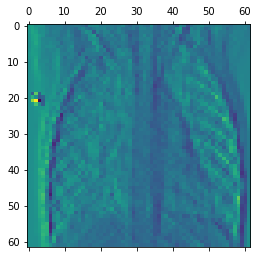

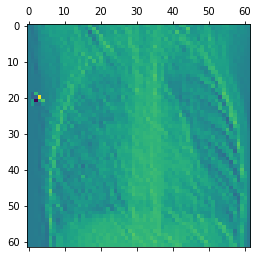

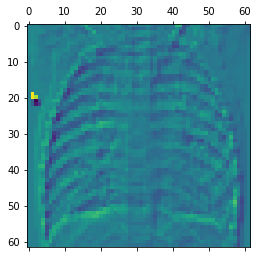

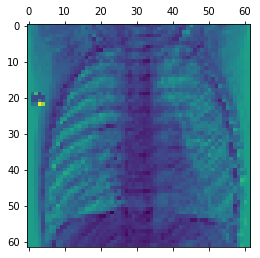

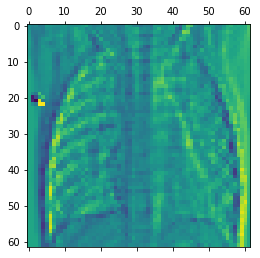

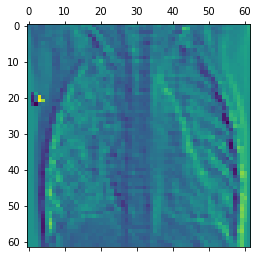

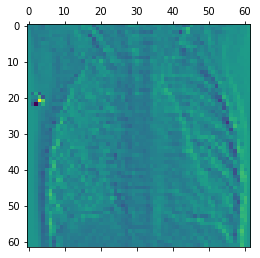

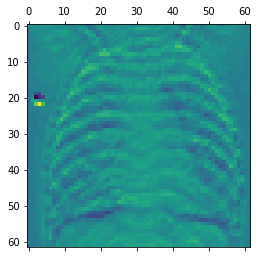

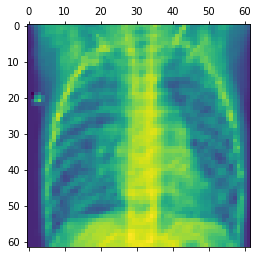

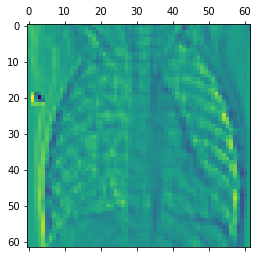

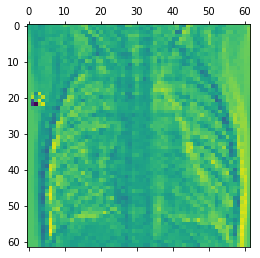

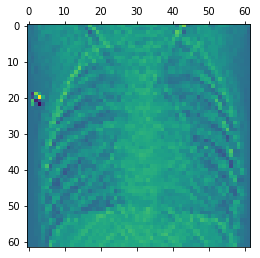

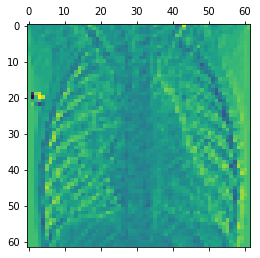

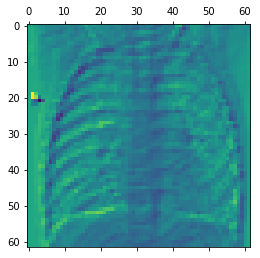

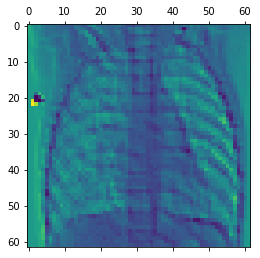

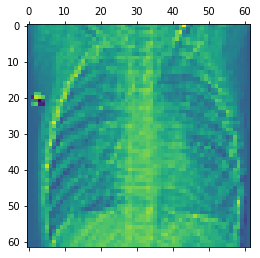

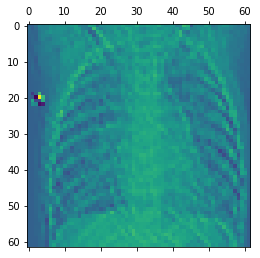

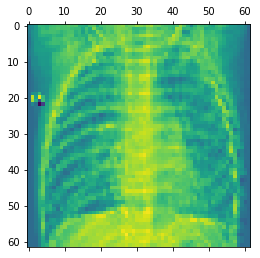

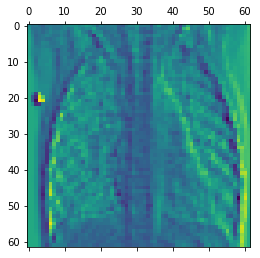

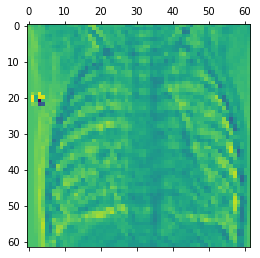

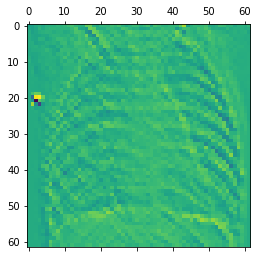

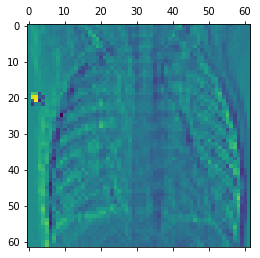

In [172]:
second_layer_activation =np.array(activations[4])
channels = second_layer_activation.shape[3]
i = 0
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1